# Similarity Matching

In [2]:
%run setup.py

In [3]:
# Load data
df_Invited = pd.read_csv(os.path.join(filepath,'factInvited.csv'))
df_Invited['Source'] = "Invited"
df_Proceedings = pd.read_csv(os.path.join(filepath,'factProceedings.csv'))
df_Proceedings['Source'] = "Proceedings"
# Append data to one dataframe
df = df_Invited.append(df_Proceedings).reset_index(drop=True)
df = df[df['Productivity'] != 0]
df['log(Paper Count)'] = np.log(df['Paper Count'])
df['index'] = df.index
df.head(3)

,Full name,Year,Conference (short),First name,Middle name,Last name,gender,Paper Count,Max Paper Count,First year paper,Age,Conference (long),Main Topic,Productivity,Source,log(Paper Count),index
1,Tadahiro Ohm,2003,ASPDAC,Tadahiro,NaN,Ohm,M,27,92,1993,10,Asia and South Pacific Design Automation Confe...,Computer Architecture,2.700000,Invited,3.295837,1
3,Gary L. Baldwi,2004,ASPDAC,Gary,L.,Baldwi,M,4,4,1962,42,Asia and South Pacific Design Automation Confe...,Computer Architecture,0.095238,Invited,1.386294,3
4,Rudy Lauwereins,2004,ASPDAC,Rudy,NaN,Lauwereins,M,112,196,1987,17,Asia and South Pacific Design Automation Confe...,Computer Architecture,6.588235,Invited,4.718499,4


## Nearest Neighbor (Male -> Female)

In [48]:
# df = df.groupby('Main Topic').get_group('M')

df_F = df[df['gender'] == "F"]
df_M = df[df['gender'] == "M"]

nbrs = NearestNeighbors(n_neighbors=1).fit(df_F[['log(Paper Count)','Productivity','Age']])
distances, indices = nbrs.kneighbors(df_M[['log(Paper Count)','Productivity','Age']])

# # Print the nearest neighbor results
for i in range(len(indices[0:10])):
    print(f"Male {df_M.iloc[i]['Full name']} is most similar to female {df_F.iloc[indices[i][0]]['Full name']} with a distance of {distances[i]}")

Male Tadahiro Ohm is most similar to female Evdokia Nikolova with a distance of [0.]
Male Gary L. Baldwi is most similar to female Andee Rubin with a distance of [1.34745412]
Male Rudy Lauwereins is most similar to female Joelle Pineau with a distance of [0.]
Male Rajeev Madhavan is most similar to female Rosario Uceda-Sosa with a distance of [0.]
Male Jan M. Rabaey is most similar to female Lu Chen with a distance of [0.]
Male Alberto Sangiovanni-Vincentelli is most similar to female Micha Sharir with a distance of [0.03038176]
Male Satoru Ito is most similar to female Meg Young with a distance of [0.]
Male Yukichi Niwa is most similar to female Yoojung Kim with a distance of [0.]
Male Rob Rutenbar is most similar to female Cindy E. Hmelo-Silver with a distance of [0.]
Male Takayasu Sakurai is most similar to female Eva Tardos with a distance of [0.]


In [49]:
# Create a new dataframe to store the results
results = pd.DataFrame(columns=['Male Name', 'Male Type', 'Year', 'Female Name', 'Female Type'])

# Iterate over each male data point and its nearest neighbor
for i in tqdm(range(len(indices))):
    male_name = df_M.iloc[i]['Full name']
    male_type = df_M.iloc[i]['Source']
    year = df_M.iloc[i]['Year']
    female_index = indices[i][0] # Index of the female in the original dataframe
    female_name = df_F.iloc[female_index]['Full name']
    female_type = df_F.iloc[female_index]['Source']
    results.loc[i] = [male_name, male_type, year, female_name, female_type]

# Print the results dataframe
print(results)

100%|██████████| 155948/155948 [08:18<00:00, 312.89it/s]

                Male Name    Male Type  Year         Female Name  Female Type
0            Tadahiro Ohm      Invited  2003    Evdokia Nikolova  Proceedings
1          Gary L. Baldwi      Invited  2004         Andee Rubin  Proceedings
2         Rudy Lauwereins      Invited  2004       Joelle Pineau  Proceedings
3         Rajeev Madhavan      Invited  2005  Rosario Uceda-Sosa  Proceedings
4           Jan M. Rabaey      Invited  2005             Lu Chen  Proceedings
...                   ...          ...   ...                 ...          ...
155943   Tiziano Dalmonte  Proceedings  2022            Miao Lin  Proceedings
155944      Tomas Svoboda  Proceedings  2022            Song Han  Proceedings
155945  Tomoyuki Yamakami  Proceedings  2022     Maya B. Gokhale  Proceedings
155946   Valentin Cassano  Proceedings  2022      Marion Neumann  Proceedings
155947      Xiaolong Wang  Proceedings  2022            Miao Liu  Proceedings

[155948 rows x 5 columns]


In [50]:
P_males = list(results.groupby('Year')['Male Type'].value_counts(normalize=True).loc[:, 'Invited'])
P_females = list(results.groupby('Year')['Female Type'].value_counts(normalize=True).loc[:, 'Invited'])
ratio = np.divide(P_females,P_males)

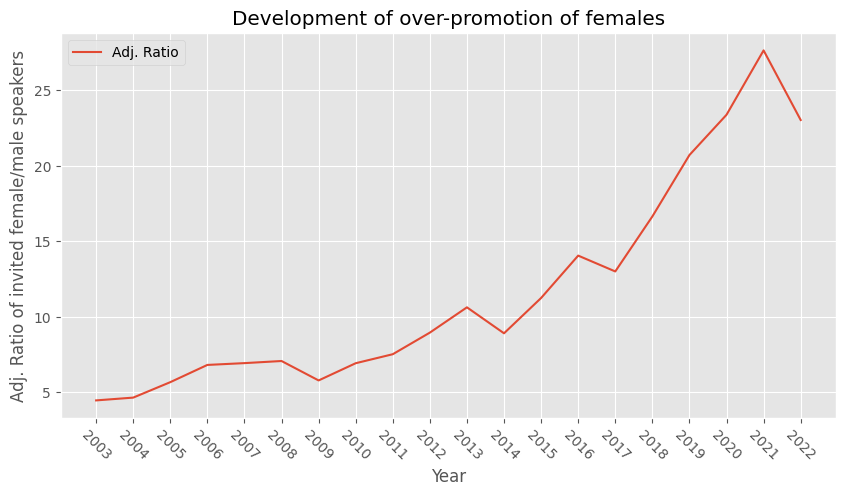

In [51]:
fig = plt.figure(figsize=(10,5))
plt.plot(range(2003,2023), ratio, '-',label="Adj. Ratio")
# plt.plot(range(2003,2023),ratio_true, label='True Ratio')
plt.xticks(range(2003,2023,1), rotation=315)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Adj. Ratio of invited female/male speakers')
plt.title('Development of over-promotion of females')
plt.show()

## Nearest Neighbor (Female -> Male)

100%|██████████| 39788/39788 [00:55<00:00, 716.79it/s]


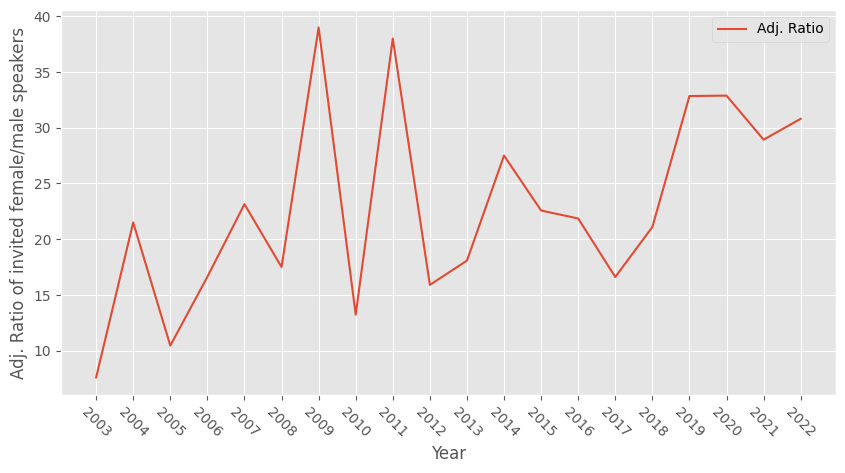

In [46]:
# df = df.groupby('Main Topic').get_group('M')

# df_F = df[df['gender'] == "M"]
# df_M = df[df['gender'] == "F"]

# nbrs = NearestNeighbors(n_neighbors=1).fit(df_F[['log(Paper Count)','Productivity','Age']])
# distances, indices = nbrs.kneighbors(df_M[['log(Paper Count)','Productivity','Age']])

# # Create a new dataframe to store the results
# results = pd.DataFrame(columns=['Male Name', 'Male Type', 'Year', 'Female Name', 'Female Type'])

# # Iterate over each male data point and its nearest neighbor
# for i in tqdm(range(len(indices))):
#     male_name = df_M.iloc[i]['Full name']
#     male_type = df_M.iloc[i]['Source']
#     year = df_M.iloc[i]['Year']
#     female_index = indices[i][0] # Index of the female in the original dataframe
#     female_name = df_F.iloc[female_index]['Full name']
#     female_type = df_F.iloc[female_index]['Source']
#     results.loc[i] = [male_name, male_type, year, female_name, female_type]


P_males = list(results.groupby('Year')['Male Type'].value_counts(normalize=True).loc[:, 'Invited'])
P_females = list(results.groupby('Year')['Female Type'].value_counts(normalize=True).loc[:, 'Invited'])
ratio = np.divide(P_females,P_males)

fig = plt.figure(figsize=(10,5))
plt.plot(range(2003,2023), ratio, '-',label="Adj. Ratio")
# plt.plot(range(2003,2023),ratio_true, label='True Ratio')
plt.xticks(range(2003,2023,1), rotation=315)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Adj. Ratio of invited female/male speakers')
plt.show()

## Cosine Similarity

In [ ]:
# Step 1: Group the data by gender
grouped_data = df.groupby('gender')

# Step 2: Calculate the cosine similarity between males and females
male_data = grouped_data.get_group('M')[['Paper Count', 'Age', 'Productivity']].reset_index()
female_data = grouped_data.get_group('F')[['Paper Count', 'Age', 'Productivity']].reset_index()
male_data_norm = (male_data - male_data.mean()) / male_data.std()
female_data_norm = (female_data - female_data.mean()) / female_data.std()
similarity_matrix = cosine_similarity(male_data_norm, female_data_norm)

# Step 3: Create a new column that stores the similar females
df['Similar Females'] = ""
for i, male in male_data.iterrows():
    similarities = similarity_matrix[i] >= .9
    similar_females = female_data.iloc[similarities]
    similar_females_index = similar_females['index'].to_list() # get the index of similar females
    df.loc[male['index'], 'Similar Females'] = ", ".join(map(str, similar_females_index)) # assign to the new column

# Step 4: replace index with names in 'Similar Females' column
name_map = dict(zip(df.index, df['Full name']))
df['Similar Females'] = df['Similar Females'].apply(lambda x: [name_map[int(i)] for i in x.split(',') if i])

df.head()

In [4]:
# Step 1: create a list of tuples containing all possible combinations of males and females who are similar
links = [(node,name) for node in list(df['Full name'].values) for name in df[df['Full name'] == node]['Similar Females'].values[0]]

# Step 2: remove duplicates
links = list(dict.fromkeys(links))

# Step 3: print
links[0:10]

Check threshold for cosine similarity

In [3]:
# takes about 1 minute
# Step 1: Group the data by gender
grouped_data = df.groupby('gender')

# Step 2: Calculate the cosine similarity between males and females
male_data = grouped_data.get_group('M')[['Paper Count', 'Age', 'Productivity']].reset_index()
female_data = grouped_data.get_group('F')[['Paper Count', 'Age', 'Productivity']].reset_index()
male_data_norm = (male_data - male_data.mean()) / male_data.std()
female_data_norm = (female_data - female_data.mean()) / female_data.std()
similarity_matrix = cosine_similarity(male_data_norm, female_data_norm)

# Step 3: Create a list to store similarity values and plot histogram
similarity_list = []
for i, male in male_data.iterrows():
    similarities = similarity_matrix[i]
    similarity_list.append(similarities)
    
combined_list = np.concatenate(similarity_list).tolist()

In [4]:
import numpy as np
from scipy.stats import percentileofscore

# Calculate the threshold that captures 95% of the data
percentile = 95
threshold_index = int(round((percentile/100) * (len(combined_list)-1)))
threshold = sorted(combined_list)[threshold_index]

print("Threshold value:", threshold)

Threshold value: 0.9526507203527652


In [ ]:
# takes a loooong time
plt.hist(arr, bins=70)
plt.xlabel('Similarity mesure between male and female speakers')
plt.ylabel('Frequency')
plt.title('Distribution of Similarities Between Male and Femlaes Speakers')

## Ratio plot

In [3]:
# Step 0: Select number of iterations
n = 1000

# Step 1: Group the data by gender
grouped_data = df.groupby('gender')

# Step 2: Calculate the cosine similarity between males and females
male_data = grouped_data.get_group('M')[['Paper Count', 'Age', 'Productivity']].reset_index()
female_data = grouped_data.get_group('F')[['Paper Count', 'Age', 'Productivity']].reset_index()
male_data_norm = (male_data - male_data.mean()) / male_data.std()
female_data_norm = (female_data - female_data.mean()) / female_data.std()
similarity_matrix = cosine_similarity(male_data_norm, female_data_norm)

# Step 3: Create a new column that stores the similar females
df['Similar Females'] = ""
for i, male in male_data.iterrows():
    similarities = similarity_matrix[i] >= .952 # threshold value
    similar_females = female_data.iloc[similarities]
    similar_females_index = similar_females['index'].to_list() # get the index of similar females
    df.loc[male['index'], 'Similar Females'] = ",".join(map(str, similar_females_index)) # assign to the new column
    
    # x ---> [ 34, 65, 89] one male speaker can have several similar female

# Step 4: Select a random female by their index n times
ratio_list = []
df['index_list'] = df['Similar Females'].apply(lambda x: [int(i) for i in x.split(',') if i])
for j in tqdm(range(0,n)):
    df['random_index'] = df['index_list'].apply(lambda x: random.choice(x) if len(x) > 0 else None).astype('Int64')
    
    # Step 5: Find the cooresponding informtion about the female speaker and save in new dataframe
    df_filtered = df[(df['gender'] == 'M') & (df['random_index'] != "")]
    df_filtered = df_filtered[['Full name', 'Year','Source','random_index']]
    
    A = pd.merge(df_filtered, df, left_on='random_index', right_on='index', how='left')
    A = A[['Full name_x', 'Source_x', 'Year_x', 'Full name_y', 'Source_y']]
    A = A.rename(columns={'Full name_x': "Full Name_M", 
                                        "Source_x": "source_M",
                                        "Year_x": "year_M",
                                        "Full name_y": "Full Name_F",
                                        "Source_y": "source_F"})
    
    # Step 6: Calculate the ratio of female invited speakers and male invited speakers per year
    P_males = A.groupby('year_M')['source_M'].value_counts(normalize=True).loc[:, 'Invited'].reset_index(name='fraction_M')
    P_females = A.groupby('year_M')['source_F'].value_counts(normalize=True).loc[:, 'Invited'].reset_index(name='fraction_F')
    ratio = np.divide(P_females['fraction_F'],P_males['fraction_M'])
    # Save the list of ratio and add new ratio after each loop
    ratio_list.append(ratio)            
            
# Step 7: Based on the list of fraction by year, calculate the mean and std.
arr = np.array(ratio_list)             
mean_ratio = np.mean(arr[:,:], axis=0)
std_ratio = np.std(arr, axis=0)

In [251]:
# df_true = df.groupby(['Year','gender'])['Source'].value_counts(normalize=True).reset_index(name='fraction')
# ratio_true = np.divide(list(df_true[(df_true['gender'] == "F") & (df_true['Source'] == "Invited")]['fraction']), list(df_true[(df_true['gender'] == "M") & (df_true['Source'] == "Invited")]['fraction']))

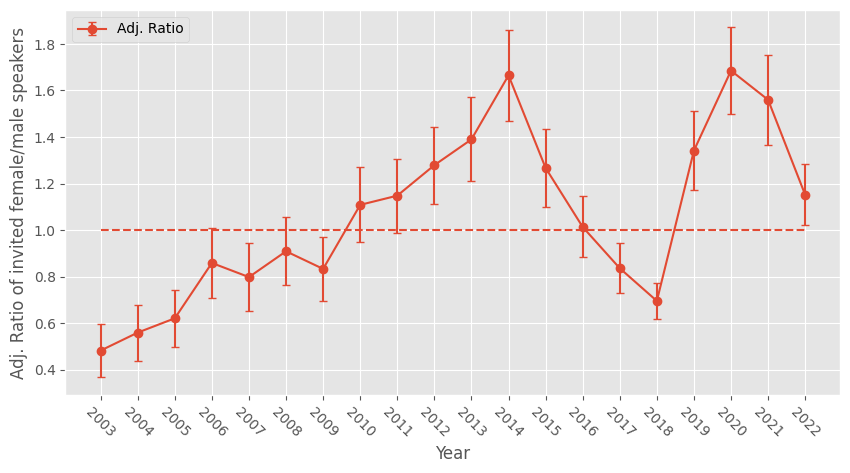

In [263]:
fig = plt.figure(figsize=(10,5))
plt.errorbar(range(2003,2023), mean_ratio, yerr=std_ratio, fmt='o-', capsize=3,label="Adj. Ratio")
# plt.plot(range(2003,2023),ratio_true, label='True Ratio')
plt.xticks(range(2003,2023,1), rotation=315)
plt.hlines(1, 2003, 2022, linestyles='dashed')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Adj. Ratio of invited female/male speakers')
plt.show()

In [3]:
'''
# Step 0: Select number of iterations
n = 1000

# Step 1: Group the data by gender
grouped_data = df.groupby('gender')

# Step 2: Calculate the cosine similarity between males and females
male_data = grouped_data.get_group('M')[['Paper Count', 'Age', 'Productivity']].reset_index()
female_data = grouped_data.get_group('F')[['Paper Count', 'Age', 'Productivity']].reset_index()
male_data_norm = (male_data - male_data.mean()) / male_data.std()
female_data_norm = (female_data - female_data.mean()) / female_data.std()
similarity_matrix = cosine_similarity(male_data_norm, female_data_norm)

# Step 3: Create a new column that stores the similar females
df['Similar Females'] = ""
for i, male in male_data.iterrows():
    similarities = similarity_matrix[i] >= .9
    similar_females = female_data.iloc[similarities]
    similar_females_index = similar_females['index'].to_list() # get the index of similar females
    df.loc[male['index'], 'Similar Females'] = ",".join(map(str, similar_females_index)) # assign to the new column
    
    # x ---> [ 34, 65, 89] one male speaker can have several similar female

# Step 4: Select a random female by their index n times
fractions = {}
df['index_list'] = df['Similar Females'].apply(lambda x: [int(i) for i in x.split(',') if i])
for j in tqdm(range(0,n)):
    df['random_index'] = df['index_list'].apply(lambda x: random.choice(x) if len(x) > 0 else None).astype('Int64')
    
    # Step 5: Find the cooresponding informtion about the female speaker and save in new dataframe
    male_list = []
    female_list = []
    year_list = []
    source_F_list = []
    source_M_list = []

    # filter before the loop
    df_filtered = row['gender'] == 'M' and row['Similar Females'] != ""

    for i, row in df.iterrows():
        if row['gender'] == 'M' and row['Similar Females'] != "":    
            male_list.append(row['Full name'])
            female_list.append(df.loc[row['random_index'],'Full name'])
            year_list.append(int(row['Year']))
            source_F_list.append(df.loc[row['random_index'],'Source'])
            source_M_list.append(row['Source'])
            
    A = pd.DataFrame({
        'name_M': male_list,
        'year_M': year_list,
        'source_M': source_M_list,
        'name_F': female_list,
        'source_F': source_F_list,
    })
            
    # Step 6: Calculate the ratio of female invited speakers per year
    A_grouped = A.groupby(['year_M', 'source_F']).size().reset_index(name='count')
    A_invited = A_grouped[A_grouped['source_F'] == 'Invited']
    A_invited_grouped = A.groupby(['year_M'])['source_F'].count().reset_index(name='total')
    B = pd.merge(A_invited, A_invited_grouped, on='year_M')
    B['fraction'] = B['count'] / B['total'] # number of females invited / total number of speakers for that year
    B = B[['year_M', 'fraction']]
    
    for index, row in B.iterrows():
        year = row['year_M']
        fraction = row['fraction']
        if year in fractions:
            fractions[year].append(fraction)
        else:
            fractions[year] = [fraction]
            
            
# Step 7: Based on the list of fraction by year, calculate the mean and std.             
C = pd.DataFrame(columns=['year', 'mean', 'std'])
for year in fractions:
    mean = sum(fractions[year]) / len(fractions[year])
    std = pd.Series(fractions[year]).std()
    C = C.append({'year': year, 'mean': mean, 'std': std}, ignore_index=True)
C['year'] = C['year'].astype(int)

# Step 8: Save table for reference
C.to_csv('Fraction_of_invited_Females.csv', index=False)
'''

100%|██████████| 1000/1000 [37:28<00:00,  2.25s/it]
